In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import MeanShift, estimate_bandwidth
import umap.umap_ as umap
from itertools import cycle

In [2]:
bh_file_path = 'Lac_de_Gras_borehole_only.csv'
df = pd.read_csv(bh_file_path, header=[0])
len(df)

224

In [3]:
df = df.dropna(subset=['UnitCode'])

In [4]:
df.Frozen = df.Frozen.str.split(pat=',').str[0]
df.Frozen = df.Frozen.eq('Yes').mul(1)

In [5]:
df.UnitCode = df.UnitCode.str.split(pat=',').str[0]
df['UnitCode'].replace(['Till '], 'Till', regex=True, inplace=True)
df.UnitCode.unique()

array(['Till', 'Organics', 'Boulder', 'Ice', 'Clay', 'Gravel/Cobbles',
       'Soil', 'Sand', 'Silt'], dtype=object)

In [6]:
parameters = ['ExIceCont_perc', 'GWCWetBase_perc', 'Frozen', 'Gravel_perc', 'Sand_perc', 'Fines_perc']
# parameters = ['ExIceCont_perc', 'GWCWetBase_perc', 'Frozen']

In [8]:
terrainTypes = ['Till']

In [9]:
terrainType = 'Till'
df_tt = df.loc[df['TerrainType'] == terrainType]
print(f'There are {len(df_tt)} samples in terrain type {terrainType}')

There are 83 samples in terrain type Till


In [10]:
depths = df_tt['SampleDepth'].to_numpy(dtype='float')
df_tt = df_tt[parameters]

In [11]:
np_tt = df_tt.to_numpy(dtype='float')
scaler = StandardScaler()
scaler.fit(np_tt)
np_tt = scaler.transform(np_tt)
np_tt.shape

(83, 6)

In [12]:
pca = decomposition.PCA()
pca.fit(np_tt)
comp_tt = pca.transform(np_tt)

In [13]:
pca.singular_values_

array([15.61115436, 11.2433207 ,  8.21896364,  6.28488065,  4.1181049 ,
        1.96716124])

In [14]:
Y = comp_tt[:,0]

## Clustering

In [15]:
bandwidth = estimate_bandwidth(np_tt, quantile=0.2)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(np_tt)
labels = ms.labels_
#labels looks like [0, 0, 0, 1, 1, 1, 1, 2, 2,....]

cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 5


In [16]:
reducer = umap.UMAP()

In [17]:
embedding = reducer.fit_transform(np_tt)
embedding.shape

(83, 2)

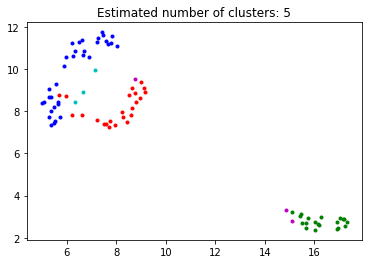

In [18]:
plt.clf()
# fig = plt.figure()
# ax = plt.axes(projection='3d')

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    plt.plot(embedding[my_members, 0], embedding[my_members, 1], col + ".")
    # plt.scatter(np_tt[my_members, 0], np_tt[my_members, 1], np_tt[my_members, 2], c=col)
    
plt.title("Estimated number of clusters: %d" % n_clusters_)
# plt.axis('equal')
plt.show()

## Logistic Regression Classificiation

In [20]:
logreg = LogisticRegression()
logreg.fit(depths.reshape(-1, 1), labels)

LogisticRegression()

In [21]:
depths_syn = np.arange(np.floor(depths.min()),np.ceil(depths.max()),0.5)
depths_syn_fine = np.arange(np.floor(depths.min()),np.ceil(depths.max()),0.1)
profile = logreg.predict(depths_syn.reshape(-1,1))
profile_fine = logreg.predict(depths_syn_fine.reshape(-1,1))

In [22]:
ind_change = np.where(profile_fine[:-1] != profile_fine[1:])[0]+1

In [23]:
ind_change = np.insert(ind_change, 0, 0)
ind_change = np.append(ind_change, len(profile_fine))

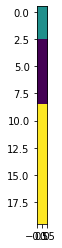

In [24]:
plt.imshow(profile.reshape(-1,1))

In [25]:
profile_samples = logreg.predict(depths.reshape(-1,1))

In [26]:
logreg.classes_

array([0, 1, 2, 3, 4], dtype=int64)

In [27]:
np.unique(profile_samples)

array([0, 1, 2], dtype=int64)

In [36]:
n_rows = len(ind_change)-1
n_cols = len(parameters) * 2 + 3
arr = np.zeros([n_rows, n_cols])

In [38]:
n_params= len(parameters)

In [50]:
for i in range(len(ind_change)-1):
    ind = ind_change[i]
    ind_next = ind_change[i+1]
    
    cl = profile_fine[ind]
    begin = depths_syn_fine[ind]
    end = depths_syn_fine[ind_next-1]

    arr[i, 0] = cl
    arr[i, 1] = begin
    arr[i, 2] = end
    
    df_class = df_tt.iloc[profile_samples==cl]
    values = np.concatenate([df_class.mean().to_numpy(), df_class.std().to_numpy()])
    arr[i,3:] = values
    
    #print(df_class.std())

In [51]:
column_values = ['layerClass', 'depthBegin', 'depthEnd']

In [52]:
mean_columns = [s + '_Mean' for s in parameters]
std_columns = [s + '_Std' for s in parameters]
column_values = column_values + mean_columns + std_columns

In [53]:
df_tt_summary = pd.DataFrame(data = arr, columns = column_values)

In [56]:
df_tt_summary.to_csv('profile_' + terrainType+'_Summary.csv')